# Test earning capacity
In this notebook we will test whether the generator structure can actually learn. Use a simple example from Pytorch.
See [source](https://gist.github.com/santi-pdp/d0e9002afe74db04aa5bbff6d076e8fe).


In [10]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import threading
import matplotlib.pyplot as plt
import Generator as gen

In [31]:
dims = 4
damles = 10000
X1 = torch.randn(10000, dims)
X2 = torch.randn(10000, dims) + 3
X = torch.cat([X1, X2], dim=0)
Y1 = torch.zeros(10000, 1)
Y2 = torch.ones(10000, 1)
Y = torch.cat([Y1, Y2], dim=0)

print(X.size())
print(Y.size())

torch.Size([20000, 4])
torch.Size([20000, 1])


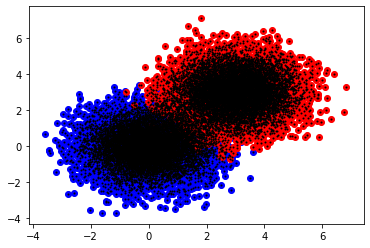

In [32]:
plt.scatter(X1[:, 0], X1[:, 1], color='b')
plt.scatter(X2[:, 0], X2[:, 1], color='r')
plt.scatter(X[:, 0], X[:, 1], color='k', s=1);

In [4]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(dims, dims)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(dims, 50)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(50, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y
    
#net = Net()
#opt = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999))
#criterion = nn.BCELoss()

In [5]:

class PolyNet(torch.nn.Module):
    def __init__(self, layer, batch_size, N, rank, imwidth, imheight):
        super(PolyNet, self).__init__()

        self.batch_size = batch_size
        self.c = 1
        self.imwidth, self.imheight = imwidth, imheight
        self.s = imwidth*imheight
        self.PolyLayer = layer(N, rank, imwidth, imheight, 0)
        self.SM = nn.Sigmoid()
        
    def BatchInParallel(self, b):
        # self.c-1 because for one channel we want to access index 0
        self.x[b, self.c-1, :] = self.PolyLayer(self.x[b, self.c-1, :])
        return

    def forward(self, x):
        # Register x as attribute for parallel access
        self.x = x
        self.x = self.x.reshape(self.batch_size, self.c, self.s) # flatten to the 1D equivalent vector

        # Start threads
        threads = []
        for batch in range(self.batch_size):
            # Perform parallel computation of the rank summation: tremendous speedup.
            process = threading.Thread(target=self.BatchInParallel, args=(batch,))
            process.start()
            threads.append(process)

        # Wait for threads to end:
        for batch in range(self.batch_size):
            threads[batch].join()

        #self.x = self.PolyLayer(self.x)
        self.x = self.x.reshape(self.batch_size, self.c, self.imwidth, self.imheight)
        return self.SM(self.x)


In [33]:
# Make the 'generator' network: in this case to be used as a feed forward network
batch_size = 1000
N = 5
rank = 6
imwidth, imheight = int(dims/2), int(dims/2)

net = gen.Generator(gen.FTT_Layer, batch_size, N, rank, imwidth, imheight, 1)
#net = PolyNet(gen.FTT_Layer, batch_size, N, rank, imwidth, imheight)

opt = torch.optim.Adam(net.parameters(), lr=0.01)
opt = torch.optim.SGD(net.parameters(), lr=0.001)

criterion = nn.BCELoss()

In [34]:
def train_epoch(model, opt, criterion, batch_size=50):
    model.train()
    losses = []
    for beg_i in range(0, X.size(0), batch_size):
        x_batch = X[beg_i:beg_i + batch_size, :].reshape(batch_size, 1, imwidth, imheight)
        y_batch = Y[beg_i:beg_i + batch_size, :]

        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)
        
        opt.zero_grad()
        # (1) Forward
        y_hat = net(x_batch).reshape(batch_size, -1)
        #y_hat = torch.sigmoid(y_hat)
        y_hat = y_hat[:, 0]
        y_batch = y_batch[:, 0]
        # (2) Compute diff
        loss = criterion(y_hat, y_batch)
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()        
        losses.append(loss.data.numpy())
    return losses

In [35]:
e_losses = []
num_epochs = 10
for e in range(num_epochs):
    print("epoch", e+1, end='\r')
    e_losses += train_epoch(net, opt, criterion, batch_size)
plt.plot(e_losses);

RuntimeError: Assertion `x >= 0. && x <= 1.' failed. input value should be between 0~1, but got -0.000062 at ../aten/src/THNN/generic/BCECriterion.c:60

In [9]:
x_t = Variable(torch.randn(1, dims)).reshape(1, 1, imwidth, imheight)
net.eval()
print(net(x_t))
x_1_t = Variable(torch.randn(1, dims) + 3)
print(net(x_1_t))


RuntimeError: shape '[100, 1, 4]' is invalid for input of size 4